### Import Dependencies 

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

### Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

### Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
latest_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date_str = latest_date_query[0]
latest_date = dt.datetime.strptime(latest_date_str, '%Y-%m-%d').date()
print("Latest Date :", latest_date)

Latest Date : 2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
yr_ago_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print("Year Ago Date :", yr_ago_date)

Year Ago Date : 2016-08-23


In [11]:
# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date > '2016-08-23').order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame and select only the date and prcp values
precip_df=pd.DataFrame(precip_scores,columns=['date','prcp'])

#  set the index to the date column
precip_df=precip_df.set_index('date')

# check and drop null values
precip_df.dropna(axis=0, how="any", inplace=True)
precip_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


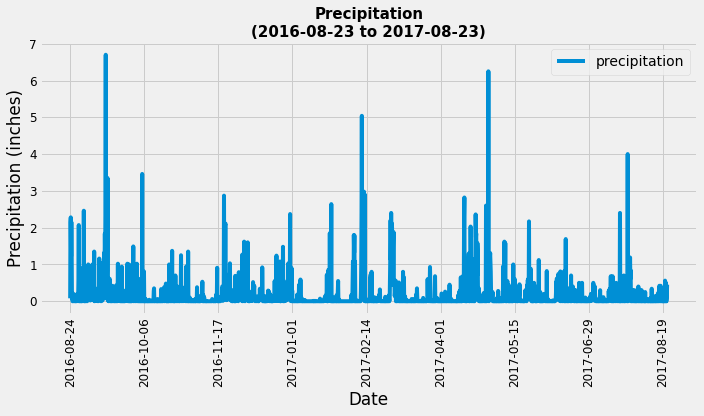

In [12]:
#Rename clolumn
precip_df = precip_df.rename(columns = {"prcp": "precipitation"})

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(10,6), fontsize=12, rot=90)
plt.title(f'Precipitation\n({yr_ago_date} to {latest_date})', fontweight = 'bold', size=15)

# Set labels
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

# Display and Save bar graph to Images folder
plt.tight_layout()
plt.savefig("Images/prcp.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = precip_df.describe()
summary_stats

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


###  Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(Station).group_by(Station.station).count()
print(f"There are {number_stations} stations in the dataset.")

There are 9 stations in the dataset.


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest temperature, highest temperature, and average temperature station.

# Determining the most active station from previous query
most_active_station = active_stations[0][0]
print (f"The most active station is {most_active_station}")
print("-----------------------------------------")

# calculate the lowest temperature
lowest_temp = session.query(Measurement.tobs).\
        filter(Measurement.station==most_active_station).order_by(Measurement.tobs).first()

print(f"Lowest temperature: {lowest_temp} degrees Fahrenheit")

# calculate highest temp
highest_temp = session.query(Measurement.tobs).\
        filter(Measurement.station==most_active_station).order_by(Measurement.tobs.desc()).first()

print(f"Highest temperature: {highest_temp} degrees Fahrenheit")

# calculate average temperature 
avg_temp = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.station==most_active_station).scalar()
print(f"Average temperature: {round(avg_temp, 2)} degrees Fahrenheit")


The most active station is USC00519281
-----------------------------------------
Lowest temperature: (54.0,) degrees Fahrenheit
Highest temperature: (85.0,) degrees Fahrenheit
Average temperature: 71.66 degrees Fahrenheit


In [19]:
last_year_tem = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date >= yr_ago_date).\
filter(Measurement.station == 'USC00519281').order_by(Measurement.date).all()

last_yr_tob=pd.DataFrame(last_year_tem, columns=['date','tobs'])

# change the date datetype to  datetime
#last_yr_tob['date'] =pd.to_datetime(temp_df['date'], format='%Y-%m-%d')

# Sort the dataframe by date
last_yr_tob=last_yr_tob.sort_values(by=['date'])

# drop the Null values
last_yr_tobs=last_yr_tob.dropna()

# set the dataframe index to date
last_yr_tobs=last_yr_tobs.set_index('date')
last_yr_tobs.head()


,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


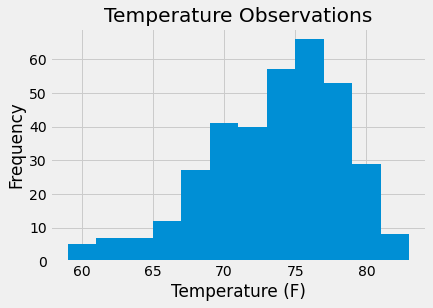

In [22]:
# plot the results as a histogram

plt.hist(last_yr_tobs['tobs'], bins=12)
plt.title("Temperature Observations")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.savefig("Images/temp_obervations.png")
plt.show()

### Close Session

In [ ]:
# Close Session
session.close()